# FINAL MODEL - Exploration and Tuning

'LinearSVC() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.3'

### Imports

In [1]:
import pandas as pd
import classes_and_methods.soam_class as soam #contains a text cleaning method
import classes_and_methods.title_data_augmenter_class as augment
import matplotlib.pyplot as plt

1068 lines from "Augement_Equipment_OPT" file downloaded for supplement
"Augement_NOCTILUCENT_CLOUDS_Wiki" string downloaded for supplement
89 lines from "Augement_NOCTILUCENT_CLOUDS_GPT" file downloaded for supplement
73 lines from "Augement_NORTHERN_LIGHTS_GPT" file downloaded for supplement


### Helper Methods

In [2]:
#Helper Methods
def category_counts(df, cat_col, print_it = True):
    """
    Provided a data frame, df, and a category column name, cat_col...
        Print a table showing the categories and their corresponding:
            -Category name
            -Category record count
            -Percentage across all categories
    """
    # Get the value counts and create a DataFrame
    table = pd.DataFrame(df[cat_col].value_counts()).reset_index()
    # Rename the columns for clarity
    table.columns = ['Subject', 'Count']
    #set percentages column
    total = sum(table['Count'])
    table['Percentages'] = table['Count']/total
    if(print_it):
        # Display the table
        print("Table of subject_type Counts:")
        print(table)
        print(f'TOTAL = {total}')
    
    return table

def original_data_percentages(df,original_data_tag,data_type_col, sub_category_col):
    """
    df, the working data frame containing a data_type col with a type tag for original data for each occurance row
    original_data_tag, a string matching the original data type tag
    data_type_col, a string matching the column name holding the data types
    sub_category_col, a string matching the column name holding subject types
    """
    #Group by and calculate the percentage of the original data taged
    result_df = df.groupby(sub_category_col)[data_type_col].value_counts(
        normalize=True).unstack().fillna(0) * 100
    
    return result_df[original_data_tag].sort_values(ascending=False)

def two_category_histogram(category1, category2, df, print_it = False):
    """
    Where:
        - string category1 counts will be represented as a single bar
        - string ategory2 counts within category1 will be represented by 
            color on the corresponding category1 bar
        - string total_counts is a column containing counts of occurance within both categories
        - df is a data frame with category1 and category2 two columns
    """
    df = df.groupby([category1, category2]).size().reset_index(name='count')
    # Create a cross-tabulation (count) of Category1 and Category2
    
    cross_tab = df.pivot_table(index=category1, columns=category2, values='count', aggfunc='sum')

    # Sort the DataFrame based on the counts of Category1 in descending order
    sorted_cross_tab = cross_tab.sum(axis=1).sort_values(ascending=False)
    cross_tab_sorted = cross_tab.loc[sorted_cross_tab.index]

    # Plot the histogram-like graph
    ax = cross_tab_sorted.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')
    
    # Set the y-axis limit to be 20% greater than the second largest subject type
    y_limit = 1.2 * sorted_cross_tab.iloc[1]
    plt.ylim(0, y_limit)

    # Annotate bars that exceed the y-axis limit
    for i, (idx, row) in enumerate(cross_tab_sorted.iterrows()):
        if row.sum() > y_limit:
            ax.annotate(f'** / / **', xy=(i, y_limit), ha='center', va='bottom', color='red')
        
    # Customize the plot
    ax.set_xlabel(category1.upper())
    ax.set_ylabel('Count')
    ax.legend(title = category2.upper(), bbox_to_anchor=(1, 1))
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    
    # Tilt x-axis tick labels at a 45-degree angle
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
    
    if print_it == True:
        # Show the plot
        print("PLOTTING CATEGORIES")
        plt.show()
    
    return(plt)

print("helper methods ready")

helper methods ready


### Loading Data

In [3]:
# Data Load (provided by Salvatore from AstroBin site)
df = pd.read_csv("data/astrobin_titles_to_subject_types.csv") #the main starting data frame
#set data types
df['subject_type'] = df['subject_type'].astype('category') #subject_type is our pre-defined categories
df['title'] = df['title'].astype(str) #title is our text data
#data set cleaning
df = df.dropna(how='all') #droping only the rows with 'na' across ALL columns
df = df.dropna(subset=['title']) #droping only the rows with 'na' ONLY in title column
df = df[df['title'] != 'nan'] #droping only the rows with 'nan' ONLY in title column
df = df[~df['title'].str.isspace()] #droping only the rows with just '  ' (white space) as title
df = df[df['title']!=''] #droping only the rows with just '' (dead space) as title
df = df.dropna(subset=['subject_type']) #droping only the rows with 'na' subject_type                                                
#cleaning out the odd '600' category, converting it to 'OTHER' (per email "Image Title Classification | AstroBin")
df['subject_type'] = df['subject_type'].replace('600','OTHER')
#title cleaning (text cleaning method can be reviewed in the appendix, referenced in imports)
df['cleaned_title'] = df['title'].apply(soam.provided_cleaning_method)

#Review the Original df
print(" -- Data loaded --")

#scale back data if testing ###########################################
sample_size = False ### set to False for full size ###
if sample_size:
    df = df.sample(n=sample_size)
#######################################################################    
df

 -- Data loaded --


,title,subject_type,solar_system_main_subject,cleaned_title
1,Zigarren Galaxie,DEEP_SKY,NaN,zigarren galaxie
2,M 16,DEEP_SKY,NaN,m 16
3,M71 - Ammasso globulare - Costellazione della ...,DEEP_SKY,NaN,m 71 ammasso globulare costellazione della fre...
4,NGC2903 A bright Galaxy in Leo,DEEP_SKY,NaN,ngc 2903 a bright galaxy in leo
5,Omicron1 Cygni Region,DEEP_SKY,NaN,omicron 1 cygni region
...,...,...,...,...
600263,"IC 1318, take 2",DEEP_SKY,NaN,ic 1318 take 2
600264,M33,DEEP_SKY,NaN,m 33
600265,M109 - 100% crop,DEEP_SKY,NaN,m 109 100 crop
600266,NGC663 and NGC457 in Cassiopeia,DEEP_SKY,NaN,ngc 663 and ngc 457 in cassiopeia


### Augment Data w/ Supplement Text

In [4]:
#1. AUGMENT THE DATA --------------------------------------
smoothing_factor = 0.3 ### As determined in the scaling notebooks
print("Original Data --------------- ")
original_counts = category_counts(df,'subject_type')

print("... Augmentation in progress... ")
#augment the df according to smoothing factor...
df_augmented = augment.title_data_augmenter(
    df, original_counts, smoothing_factor, augment.supplement_params)
# ---------------------------------------------------------

#A Note on augment.supplement_params:
#-- All subject_type categories are allowed to up-sample with
#    both straigh/raw re-sampling and synonym-swapping (50/50)
#    if original data is short of the new smoothed title count limit.
#-- 'GEAR' subject_type data can also be supplemented with the 
#    equipment names from the "Augement_Equipment_OPT.txt" file 
#    (Telescope, Camera, and Mount gear, OPT sale items)
#-- 'NORTHERN_LIGHTS' subject_type can also be supplemented with
#    ChatGPT generated descriptions of Aurora and northern lights
#    from "Augement_NORTHERN_LIGHTS_GPT.txt" file
#-- 'NOCTILUCENT_CLOUDS' subject_type can also use both of the 
#    following text supplements:
#    - A Wikipedia scraped description of Noctilucent Clouds 
#      https://en.wikipedia.org/wiki/Noctilucent_cloud from the
#      "Augement_NOCTILUCENT_CLOUDS_Wiki.txt" file
#    - ChatGPT generated descriptions of Noctilucent Clouds
#      from "Augement_NOCTILUCENT_CLOUDS_GPT.txt" file 

# FUTURE WORK ---
# - AN EVER CHANGING UNIVERSE:
#   As new objects come into popularity (like the NEOWISE comet or named solar flares / storms)
#   The Augmentation step would be an appropriate intervention space to add new data to the model
#   It would be a matter of updateing the augment.supplement_params to point a
#   specific subject type category to a new text file with multiple rows of synthetic data 
#   Containing the new description(s).
# - This could be as simple as repeating shuffled descriptions you would like to get the model 
#   updated to recognize, across hundreds of file lines just be sure to vary those repeated lines 
#   with some noise, like a synonym swap.
#   The way you brew up the supplement text file is up to you (like a color palette is to an artist)
print("Augmented Data --------------- ")
augmented_counts = category_counts(df_augmented,'subject_type')

Original Data --------------- 
Table of subject_type Counts:
              Subject   Count  Percentages
0            DEEP_SKY  444255     0.751298
1        SOLAR_SYSTEM  111233     0.188111
2          WIDE_FIELD   20108     0.034005
3               OTHER    9670     0.016353
4                GEAR    3587     0.006066
5         STAR_TRAILS    1628     0.002753
6     NORTHERN_LIGHTS     674     0.001140
7  NOCTILUCENT_CLOUDS     162     0.000274
TOTAL = 591317
... Augmentation in progress... 
Augmented Data --------------- 
Table of subject_type Counts:
              Subject   Count  Percentages
0            DEEP_SKY  333153     0.563408
1        SOLAR_SYSTEM  100037     0.169176
2          WIDE_FIELD   36250     0.061304
3               OTHER   28942     0.048945
4                GEAR   24686     0.041747
5         STAR_TRAILS   23314     0.039427
6     NORTHERN_LIGHTS   22646     0.038297
7  NOCTILUCENT_CLOUDS   22290     0.037695
TOTAL = 591318


#### A QUICK LOOK AT THE AUGMENTED DATA

In [5]:
df_a = df[df['subject_type'] == 'NORTHERN_LIGHTS']
df_a

,title,subject_type,solar_system_main_subject,cleaned_title
1733,Multicolor Aurora Crown,NORTHERN_LIGHTS,NaN,multicolor aurora crown
1771,Aurora Borealis,NORTHERN_LIGHTS,NaN,aurora borealis
5739,"Southern Lights in Tatura, Victoria, Australia.",NORTHERN_LIGHTS,NaN,southern lights in tatura victoria australia
5950,"Milky Way and the Southern Lights in Tatura, V...",NORTHERN_LIGHTS,NaN,milky way and the southern lights in tatura vi...
5951,Southern Lights Tatura Victoria,NORTHERN_LIGHTS,NaN,southern lights tatura victoria
...,...,...,...,...
466261,Iceland - Northern Lights,NORTHERN_LIGHTS,NaN,iceland northern lights
472495,Aurora polar lights Animation,NORTHERN_LIGHTS,NaN,aurora polar lights animation
495187,Polaris Aurora,NORTHERN_LIGHTS,OTHER,polaris aurora
498523,Aurora in Myrmansk 18.03.2015,NORTHERN_LIGHTS,OTHER,aurora in myrmansk 18 03 2015


### Train Model - 
#### Exploration with a parameter grid, kernel summerization, and piplines

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Collect x = title text and y = subject_type categories
x = df_augmented['title']
y = df_augmented['subject_type']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=333)

# Create a pipeline with TfidfVectorizer and LinearSVC
text_classifier = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    #https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
                             # Model Type, fixed Settings -----------------------------------------
    ('classifier', LinearSVC(penalty='l1', #The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.L1 regularization tends to produce sparse models, meaning it encourages some of the coefficients to become exactly zero. This can be useful when you suspect that many features are irrelevant or redundant.
                             loss='squared_hinge', #Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss. The combination of penalty='l1' and loss='hinge' is not supported.
                             dual=False, # dual="auto" will choose the value of the parameter automatically, based on the values of n_samples, n_features, loss, multi_class and penalty. If n_samples < n_features and optimizer supports chosen loss, multi_class and penalty, then dual will be set to True, otherwise it will be set to False. 
                             multi_class='ovr', #default is ’ovr’, Determines the multi-class strategy if y contains more than two classes. "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored. 
                             fit_intercept=True, #default true, When fit_intercept is True, the instance vector x becomes [x_1, ..., x_n, intercept_scaling], i.e. a “synthetic” feature with a constant value equal to intercept_scaling is appended to the instance vector. Whether or not to fit an intercept. If set to True, the feature vector is extended to include an intercept term: [x_1, ..., x_n, 1], where 1 corresponds to the intercept. If set to False, no intercept will be used in calculations (i.e. data is expected to be already centered).
                             intercept_scaling=1, #When fit_intercept is True, the instance vector x becomes [x_1, ..., x_n, intercept_scaling], i.e. a “synthetic” feature with a constant value equal to intercept_scaling is appended to the instance vector. The intercept becomes intercept_scaling * synthetic feature weight. #Dealing with Imbalanced Classes: If your dataset has imbalanced classes, meaning that one class has significantly fewer samples than the other, adjusting intercept_scaling might help to better balance the influence of the intercept term in the decision boundary. Note that liblinear internally penalizes the intercept, treating it like any other term in the feature vector. To reduce the impact of the regularization on the intercept, the intercept_scaling parameter can be set to a value greater than 1; the higher the value of intercept_scaling, the lower the impact of regularization on it. Then, the weights become [w_x_1, ..., w_x_n, w_intercept*intercept_scaling], where w_x_1, ..., w_x_n represent the feature weights and the intercept weight is scaled by intercept_scaling. This scaling allows the intercept term to have a different regularization behavior compared to the other features.
                             class_weight='balanced', #Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). f set to 'balanced', the class weights are automatically adjusted based on the inverse of the class frequencies in the input data. This is particularly useful for imbalanced datasets.
                             #-----------------------------------------------------------------
                             # To be managed in a Paramet Grid -------------------------   
                             tol=0.1, #default value of 1e-4 is often suitable, Smaller values of tol result in a more accurate solution, but they may also lead to longer training times. Larger values of tol can cause the algorithm to converge more quickly but might result in a less accurate solution.
                             #C=10.0, # The LinearSVC algorithm aims to find a decision boundary that separates the classes in the training data. The regularization term 'C' penalizes the model for having large coefficients, preventing the model from fitting the noise in the training data. The C parameter allows you to adjust the balance between fitting the training data well and keeping the model's coefficients small.Smaller C: Stronger regularization, which may result in a simpler model with smaller coefficients. It helps prevent overfitting by discouraging the model from fitting the noise in the training data.Larger C: Weaker regularization, which may allow the model to fit the training data more closely. This can be useful when the training data is noisy or when you want the model to be more flexible. 'C' Must be strictly positive 
                             max_iter=1000, #The maximum number of iterations to be run.
                             # --------------------------------------------------------
                             #General Settings ---------------------
                             verbose=0, #set as needed... default=0, may impact multithreading if not 0, takes advantage of a per-process runtime setting in liblinear that, if enabled, may not work properly in a multithreaded context.
                             random_state=333 #set as needed ... 
                            )# -------------------------------------  
    )
])

# Set up parameter grid for GridSearchCV
param_grid = {
    #'tfidf__max_features': [1000,5000,10000],  # Adjust the number of features as needed
    #'classifier__max_iter': [1000, 2500, 5000],
    'classifier__C': [0.1,1,10,100], #trade-off between achieving a low training error and a low testing error. A small 'C' encourages a broader margin (more tolerance for misclassification) but may lead to more training points being misclassified. 
    #'classifier__tol': [0.1]
    #'classifier__gamma': [0.1,0.15, 0.5] #Use only when the Kernal type selected allows. Helpful when dealing with sparse data, especially if it's skewed, a small 'gamma' can be beneficial. It acts as a regularization parameter for the kernel and controls the shape of the decision boundary. A small 'gamma' implies a larger similarity radius, and vice versa. 
}

# Define the weighted F1 scorer
#weighted_f1_scorer = make_scorer(f1_score, average='weighted') # can be used like "scoring=weighted_f1_scorer"

# Perform GridSearchCV for parameter tuning                          #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid_search = GridSearchCV(text_classifier, param_grid, cv=10, scoring='balanced_accuracy') #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score
grid_search.fit(x_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


print("PARAM GRID ---------------------------------------------------------------")
print(grid_search)
print("Best Model PARAMETERS ----------------------------------------------------")
print(best_model)
print(grid_search.best_params_)

Accuracy: 0.9247277277954407
Classification Report:
                     precision    recall  f1-score   support

          DEEP_SKY       0.96      0.94      0.95     66459
              GEAR       0.91      0.96      0.94      5017
NOCTILUCENT_CLOUDS       0.97      0.98      0.98      4453
   NORTHERN_LIGHTS       0.97      0.99      0.98      4502
             OTHER       0.78      0.67      0.72      5807
      SOLAR_SYSTEM       0.92      0.96      0.94     20048
       STAR_TRAILS       0.93      0.95      0.94      4714
        WIDE_FIELD       0.69      0.78      0.74      7264

          accuracy                           0.92    118264
         macro avg       0.89      0.90      0.90    118264
      weighted avg       0.93      0.92      0.92    118264

PARAM GRID ---------------------------------------------------------------
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
  

## Results communicated
#### FIRST DRAFT

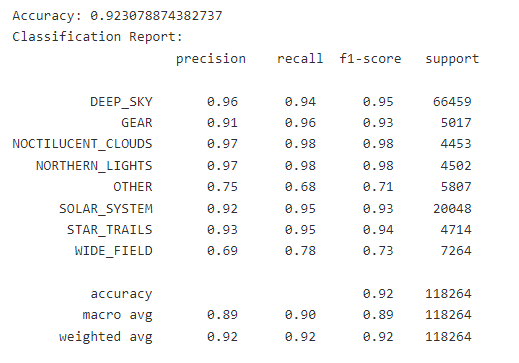

#### SECOND DRAFT
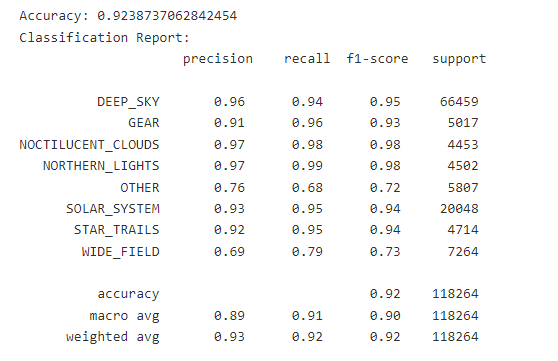

#### FINAL DRAFT
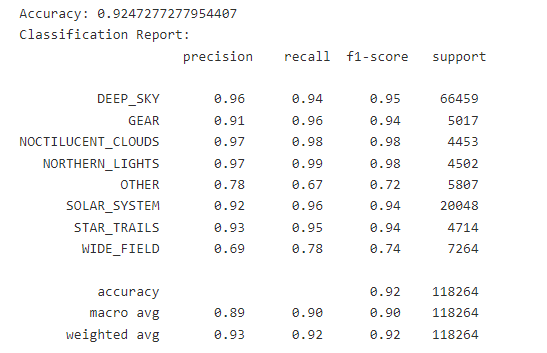

##### PARAMETER RESULTS

In [7]:
print("PARAM GRID ---------------------------------------------------------------")
print(grid_search)
print("Best Model PARAMETERS ----------------------------------------------------")
print(best_model)
print(grid_search.best_params_)

PARAM GRID ---------------------------------------------------------------
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('classifier',
                                        LinearSVC(class_weight='balanced',
                                                  dual=False, penalty='l1',
                                                  random_state=333,
                                                  tol=0.1))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100]},
             scoring='balanced_accuracy')
Best Model PARAMETERS ----------------------------------------------------
Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 LinearSVC(C=1, class_weight='balanced', dual=False,
                           penalty='l1', random_state=333, tol=0.1))])
{'classifier__C': 1}


## Results

#### First Run... n = 10,000 titles

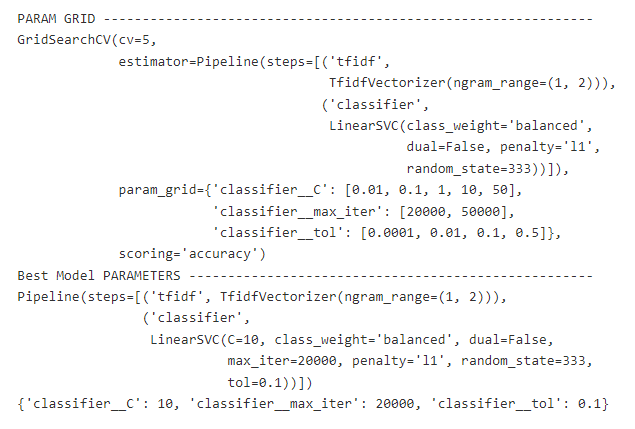

#### Second Run... n = 10,000 titles
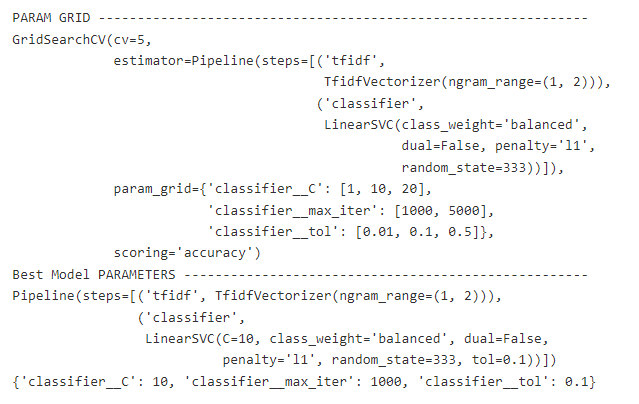

#### Final Run... n = 10,000 titles
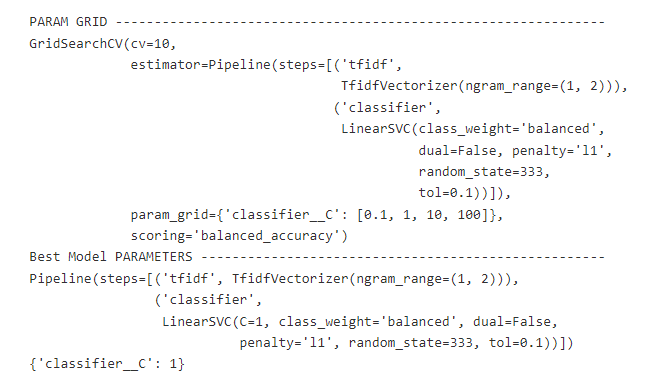

### Percentages of Original AstroBin Title Data in Augmented Training Data

In [8]:
temp_df = category_counts(df_augmented,'subject_type',print_it=False)
temp_df['(%)'] = (temp_df['Percentages']*100).round(2)
print("Subject Type Distributions")
temp_df.drop('Percentages', axis=1)

Subject Type Distributions


,Subject,Count,(%)
0,DEEP_SKY,333153,56.34
1,SOLAR_SYSTEM,100037,16.92
2,WIDE_FIELD,36250,6.13
3,OTHER,28942,4.89
4,GEAR,24686,4.17
5,STAR_TRAILS,23314,3.94
6,NORTHERN_LIGHTS,22646,3.83
7,NOCTILUCENT_CLOUDS,22290,3.77


In [9]:
print("Original Data in Subject Types (%)")
original_data_percentages(df_augmented,'sampled','augmentation', 'subject_type')

Original Data in Subject Types (%)


subject_type
DEEP_SKY              100.000000
SOLAR_SYSTEM          100.000000
WIDE_FIELD             55.470345
OTHER                  33.411651
GEAR                   14.530503
STAR_TRAILS             6.982929
NORTHERN_LIGHTS         2.976243
NOCTILUCENT_CLOUDS      0.726783
Name: sampled, dtype: float64

PLOTTING CATEGORIES


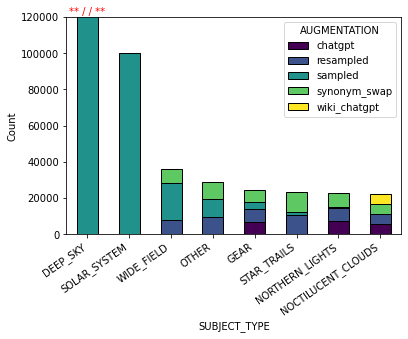

<module 'matplotlib.pyplot' from 'C:\\Users\\zachj\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [10]:
two_category_histogram('subject_type', 'augmentation', df_augmented, print_it = True)

PLOTTING CATEGORIES


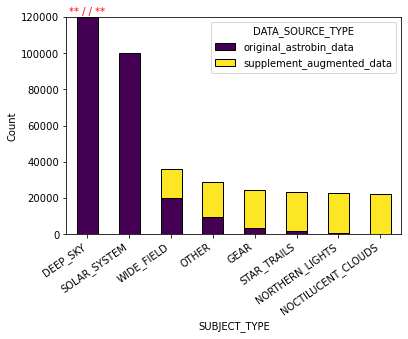

data_source_type,original_astrobin_data,supplement_augmented_data
subject_type,,
DEEP_SKY,100.00,0.00
SOLAR_SYSTEM,100.00,0.00
WIDE_FIELD,55.47,44.53
OTHER,33.41,66.59
GEAR,14.53,85.47
STAR_TRAILS,6.98,93.02
NORTHERN_LIGHTS,2.98,97.02
NOCTILUCENT_CLOUDS,0.73,99.27


In [11]:
df_augmented['data_source_type'] = (
    df_augmented['augmentation'] == 'sampled'
).replace({True: 'original_astrobin_data',False: 'supplement_augmented_data'})

two_category_histogram('subject_type', 'data_source_type', df_augmented, print_it = True)   

# TEMP DF ----------------------------------------
temp_df = df_augmented
#temp_df.rename(columns={'data_source_type': 'Data Percentages'}, inplace=True)
temp_df = (temp_df.groupby('subject_type')['data_source_type'].value_counts(normalize=True).unstack().fillna(0)*100).round(2)
#temp_df.sort_values(by='original_astrobin_data',ascending = False)
temp_df.sort_values(by='original_astrobin_data',ascending = False)
# -------------------------------------------------

### APPLICATION OF THE MODEL -- TESTING

Salvator would like the model to return a best fit category for an input title text
##### What I would like to do:
* Export a final model
* Make a python function that can import the model, along with a text cleaning method
* The function would then take a "new_text" and return the top three category options
* these top three categories could be provided to the user in a tick-box format (or maybe just a radio button if only one category is allowed in the form application on the website)
* I have not found a good way to provide a single useful number for a confidence score for the single category prediction... providing a "top three" choice to the user may standardize this image categorizing inputs with the users... 

In [12]:
# Display predicted class for new text
new_text = ["Hello World",
            "fruit loop",
            "my telescope pointed at M31", 
            "Backyard Northern Lights", 
            ""
           ]
cleaned_text = [soam.provided_cleaning_method(text) for text in new_text]
predicted_category = best_model.predict(cleaned_text)
predicted_scores = best_model.decision_function(cleaned_text)


print("Predicted Category:", predicted_category)

top_categories = []
for scores in predicted_scores:
    temp_dict = dict(zip(scores,best_model.classes_))
    # Get the top N largest scores
    n = 3
    top_scores = sorted(temp_dict.keys(), reverse=True)[:n]
    # Retrieve the categorys corresponding to the top scores
    top_values = [temp_dict[key] for key in top_scores]
    top_categories.append(top_values)
dict(zip(new_text,top_categories))

Predicted Category: ['OTHER' 'DEEP_SKY' 'WIDE_FIELD' 'NORTHERN_LIGHTS' 'DEEP_SKY']


{'Hello World': ['OTHER', 'WIDE_FIELD', 'SOLAR_SYSTEM'],
 'fruit loop': ['DEEP_SKY', 'SOLAR_SYSTEM', 'WIDE_FIELD'],
 'my telescope pointed at M31': ['WIDE_FIELD', 'GEAR', 'OTHER'],
 'Backyard Northern Lights': ['NORTHERN_LIGHTS', 'WIDE_FIELD', 'OTHER'],
 '': ['DEEP_SKY', 'SOLAR_SYSTEM', 'OTHER']}

# EXPORT / IMPORT

In [13]:
import joblib
# EXPORT -- Save the model to a file
joblib.dump(best_model, './data/full_model.joblib')

['./data/full_model.joblib']

In [14]:
# IMPORT --- Load the model from the file
imported_model = joblib.load('./data/full_model.joblib')

#TEST the import
new_text = ["A mountain sky with a comet",
            "Milky Way in the Mountains",
            "Pluto the Dog!", 
            "Pluto the Planet!",
            "The CPC1100 Ready... To... Go!",
            "What is the difference between a fruit loop and the large hadron collider? :)"
           ]
cleaned_text = [soam.provided_cleaning_method(text) for text in new_text]

predicted_scores = imported_model.decision_function(cleaned_text)

top_categories = []
for scores in predicted_scores:
    temp_dict = dict(zip(scores,imported_model.classes_))
    # Get the top N largest scores
    n = 3
    top_scores = sorted(temp_dict.keys(), reverse=True)[:n]
    # Retrieve the categorys corresponding to the top scores
    top_values = [temp_dict[key] for key in top_scores]
    top_categories.append(top_values)
    
dict(zip(new_text,top_categories)) #good Test

{'A mountain sky with a comet': ['WIDE_FIELD', 'NOCTILUCENT_CLOUDS', 'OTHER'],
 'Milky Way in the Mountains': ['WIDE_FIELD', 'OTHER', 'DEEP_SKY'],
 'Pluto the Dog!': ['DEEP_SKY', 'SOLAR_SYSTEM', 'OTHER'],
 'Pluto the Planet!': ['SOLAR_SYSTEM', 'WIDE_FIELD', 'STAR_TRAILS'],
 'The CPC1100 Ready... To... Go!': ['GEAR', 'WIDE_FIELD', 'STAR_TRAILS'],
 'What is the difference between a fruit loop and the large hadron collider? :)': ['DEEP_SKY',
  'SOLAR_SYSTEM',
  'OTHER']}

In [15]:
df

,title,subject_type,solar_system_main_subject,cleaned_title
1,Zigarren Galaxie,DEEP_SKY,NaN,zigarren galaxie
2,M 16,DEEP_SKY,NaN,m 16
3,M71 - Ammasso globulare - Costellazione della ...,DEEP_SKY,NaN,m 71 ammasso globulare costellazione della fre...
4,NGC2903 A bright Galaxy in Leo,DEEP_SKY,NaN,ngc 2903 a bright galaxy in leo
5,Omicron1 Cygni Region,DEEP_SKY,NaN,omicron 1 cygni region
...,...,...,...,...
600263,"IC 1318, take 2",DEEP_SKY,NaN,ic 1318 take 2
600264,M33,DEEP_SKY,NaN,m 33
600265,M109 - 100% crop,DEEP_SKY,NaN,m 109 100 crop
600266,NGC663 and NGC457 in Cassiopeia,DEEP_SKY,NaN,ngc 663 and ngc 457 in cassiopeia


In [16]:
crashme

NameError: name 'crashme' is not defined

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_a = df.sample(5000)

# Sample data
titles = df_a['cleaned_title']

categories = df_a['subject_type']

# Create a CountVectorizer to convert text into a matrix of token counts
vectorizer = CountVectorizer()
titles_matrix = vectorizer.fit_transform(titles)

# Initialize the category similarity matrix
num_categories = len(set(categories))
category_similarity_matrix = np.zeros((num_categories, num_categories))

# Calculate the cosine similarity for each pair of categories
unique_categories = list(set(categories))
for i in range(num_categories):
    for j in range(i, num_categories):
        category_i_indices = [index for index, cat in enumerate(categories) if cat == unique_categories[i]]
        category_j_indices = [index for index, cat in enumerate(categories) if cat == unique_categories[j]]
        
        category_i_matrix = titles_matrix[category_i_indices]
        category_j_matrix = titles_matrix[category_j_indices]
        
        # Compute cosine similarity between titles in the two categories
        similarity = np.mean(cosine_similarity(category_i_matrix, category_j_matrix))
        
        # Assign the similarity to the corresponding entry in the matrix
        category_similarity_matrix[i, j] = similarity
        category_similarity_matrix[j, i] = similarity  # The matrix is symmetric

# Print the category similarity matrix
print("Category Similarity Matrix:")
print(category_similarity_matrix)

# Convert the category similarity matrix to a DataFrame for seaborn
category_similarity_df = pd.DataFrame(category_similarity_matrix, index=unique_categories, columns=unique_categories)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(category_similarity_df, annot=True, cmap='BuGn', fmt=".2f")

# Tilt the column labels (x-axis labels)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30, ha='right')

# Set plot labels and title
plt.xlabel("Categories")
plt.ylabel("Categories")
plt.title("Category Similarity Heatmap")

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Replace this with your actual text data and labels
test_df = df_augmented.sample(100)
texts = test_df['title']
labels = test_df['subject_type'].astype('category')

# Split the data into training and testing sets
texts_train, texts_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(texts_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

# Train a LinearSVC model
clf = LinearSVC()
clf.fit(X_train_pca, y_train)

# Create a meshgrid for plotting
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Vectorize the points in the meshgrid using the same TF-IDF vectorizer
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
meshgrid_tfidf = vectorizer.transform([" ".join(map(str, point)) for point in meshgrid_points])
Z = clf.predict(pca.transform(meshgrid_tfidf.toarray()))
Z = Z.reshape(xx.shape)


# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', marker='o', s=80, linewidth=1.5)
plt.title('LinearSVC Decision Boundaries')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
df_augmented.sample(100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate synthetic data (replace this with your text data)
test_df = df_augmented.sample(1000)
X = test_df['title']
y = test_df['subject_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Train a LinearSVC model
clf = LinearSVC()
clf.fit(X_train_pca, y_train)

# Create a meshgrid for plotting
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict the classes for each point in the meshgrid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', marker='o', s=80, linewidth=1.5)
plt.title('LinearSVC Decision Boundaries')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Replace this with your actual text data and labels
test_df = df_augmented.sample(1000)
texts = test_df['title']
labels  = test_df['subject_type']


# Split the data into training and testing sets
texts_train, texts_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(texts_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

# Train a LinearSVC model
clf = LinearSVC()
clf.fit(X_train_pca, y_train)

# Create a meshgrid for plotting
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Vectorize the points in the meshgrid using the same TF-IDF vectorizer
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
meshgrid_tfidf = vectorizer.transform([" ".join(point) for point in meshgrid_points.astype(str)])
Z = clf.predict(meshgrid_tfidf.toarray())
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', marker='o', s=80, linewidth=1.5)
plt.title('LinearSVC Decision Boundaries')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_20newsgroups

# Load a sample dataset for illustration (you can use your own dataset)
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Replace this with your actual text data and labels
texts = ["m 27 dumbbell nebula with a lil bit of ha", ...]
labels = [0, 1, ...]

# Split the data into training and testing sets
texts_train, texts_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(texts_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

# Train a LinearSVC model
clf = LinearSVC()
clf.fit(X_train_pca, y_train)

# Create a meshgrid for plotting
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Vectorize the points in the meshgrid using the same TF-IDF vectorizer
meshgrid_tfidf = vectorizer.transform([" ".join(["sample"] * X_train_tfidf.shape[1]) for _ in range(xx.size)])
Z = clf.predict(meshgrid_tfidf.toarray())
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', marker='o', s=80, linewidth=1.5)
plt.title('LinearSVC Decision Boundaries')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
text_classifier = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),

In [ ]:
text_classifier['tfidf'].fit_transform(x)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Assuming X, y are your feature matrix and labels
pca = PCA(n_components=2)
x_v = text_classifier['tfidf'].fit_transform(x)
x_pca = pca.fit_transform(x_v)

clf = imported_model
clf.fit(x_pca, y)

# Plot decision boundary in the reduced space
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary in Reduced Space')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification

x = df_augmented['title']
y = df_augmented['subject_type']

# Plot decision boundary
h = .02  # step size in the mesh
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = imported_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('LinearSVC Decision Boundary')
plt.show()


In [ ]:
crashme

## Final Model Settings
{'classifier__C': 10, 'classifier__max_iter': 1000, 'classifier__tol': 0.1}

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Collect x = title text and y = subject_type categories
x = df_augmented['title']
y = df_augmented['subject_type']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=333)

# Create a pipeline with TfidfVectorizer and LinearSVC
text_classifier = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    #https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
                             # Model Type Hard Settings -----------------------------------------
    ('classifier', LinearSVC(penalty='l1', #The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.L1 regularization tends to produce sparse models, meaning it encourages some of the coefficients to become exactly zero. This can be useful when you suspect that many features are irrelevant or redundant.
                             loss='squared_hinge', #Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss. The combination of penalty='l1' and loss='hinge' is not supported.
                             dual=False, # dual="auto" will choose the value of the parameter automatically, based on the values of n_samples, n_features, loss, multi_class and penalty. If n_samples < n_features and optimizer supports chosen loss, multi_class and penalty, then dual will be set to True, otherwise it will be set to False. 
                             multi_class='ovr', #default is ’ovr’, Determines the multi-class strategy if y contains more than two classes. "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored. 
                             fit_intercept=True, #default true, When fit_intercept is True, the instance vector x becomes [x_1, ..., x_n, intercept_scaling], i.e. a “synthetic” feature with a constant value equal to intercept_scaling is appended to the instance vector. Whether or not to fit an intercept. If set to True, the feature vector is extended to include an intercept term: [x_1, ..., x_n, 1], where 1 corresponds to the intercept. If set to False, no intercept will be used in calculations (i.e. data is expected to be already centered).
                             intercept_scaling=1, #When fit_intercept is True, the instance vector x becomes [x_1, ..., x_n, intercept_scaling], i.e. a “synthetic” feature with a constant value equal to intercept_scaling is appended to the instance vector. The intercept becomes intercept_scaling * synthetic feature weight. #Dealing with Imbalanced Classes: If your dataset has imbalanced classes, meaning that one class has significantly fewer samples than the other, adjusting intercept_scaling might help to better balance the influence of the intercept term in the decision boundary. Note that liblinear internally penalizes the intercept, treating it like any other term in the feature vector. To reduce the impact of the regularization on the intercept, the intercept_scaling parameter can be set to a value greater than 1; the higher the value of intercept_scaling, the lower the impact of regularization on it. Then, the weights become [w_x_1, ..., w_x_n, w_intercept*intercept_scaling], where w_x_1, ..., w_x_n represent the feature weights and the intercept weight is scaled by intercept_scaling. This scaling allows the intercept term to have a different regularization behavior compared to the other features.
                             class_weight='balanced', #Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). f set to 'balanced', the class weights are automatically adjusted based on the inverse of the class frequencies in the input data. This is particularly useful for imbalanced datasets.
                             #-----------------------------------------------------------------
                             # To be managed in a Paramet Grid -------------------------   
                             tol=0.1, #default value of 1e-4 is often suitable, Smaller values of tol result in a more accurate solution, but they may also lead to longer training times. Larger values of tol can cause the algorithm to converge more quickly but might result in a less accurate solution.
                             C=10.0, # The LinearSVC algorithm aims to find a decision boundary that separates the classes in the training data. The regularization term 'C' penalizes the model for having large coefficients, preventing the model from fitting the noise in the training data. The C parameter allows you to adjust the balance between fitting the training data well and keeping the model's coefficients small.Smaller C: Stronger regularization, which may result in a simpler model with smaller coefficients. It helps prevent overfitting by discouraging the model from fitting the noise in the training data.Larger C: Weaker regularization, which may allow the model to fit the training data more closely. This can be useful when the training data is noisy or when you want the model to be more flexible. 'C' Must be strictly positive 
                             max_iter=1000, #The maximum number of iterations to be run.
                             # --------------------------------------------------------
                             #General Settings ---------------------
                             verbose=0, #set as needed... default=0, may impact multithreading if not 0, takes advantage of a per-process runtime setting in liblinear that, if enabled, may not work properly in a multithreaded context.
                             random_state=333 #set as needed ... 
                            )# -------------------------------------  
    )
])

# Set up parameter grid for GridSearchCV (if any are needed to be tried)
param_grid = {
    #'tfidf__max_features': [1000,5000,10000],  # Adjust the number of features as needed
    #'classifier__max_iter': [1000, 5000],
    #'classifier__C': [1,10,20], #trade-off between achieving a low training error and a low testing error. A small 'C' encourages a broader margin (more tolerance for misclassification) but may lead to more training points being misclassified. 
    #'classifier__tol': [0.01, 0.1, 0.5]
    #'classifier__gamma': [0.1,0.15, 0.5] #Use only when the Kernal type selected allows. Helpful when dealing with sparse data, especially if it's skewed, a small 'gamma' can be beneficial. It acts as a regularization parameter for the kernel and controls the shape of the decision boundary. A small 'gamma' implies a larger similarity radius, and vice versa. 
}

# Define the weighted F1 scorer
#weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV for parameter tuning
grid_search = GridSearchCV(text_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

In [ ]:
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Collect x = title text and y = subject_type categories
x = df_augmented['title']
y = df_augmented['subject_type']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=333)

# Create a pipeline with TfidfVectorizer and LinearSVC
text_classifier = Pipeline([
    #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    #https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem
    ('kernel_apprx',Nystroem(kernel='rbf', #Kernel map to be approximated. A callable should accept two arguments and the keyword arguments passed to this object as kernel_params, and should return a floating point number.
                             gamma=None, #Gamma parameter for the RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels. Interpretation of the default value is left to the kernel; see the documentation for sklearn.metrics.pairwise. Ignored by other kernels.
                             coef0=None, #Zero coefficient for polynomial and sigmoid kernels. Ignored by other kernels.
                             degree=None, #Degree of the polynomial kernel. Ignored by other kernels.
                             kernel_params=None, #Additional parameters (keyword arguments) for kernel function passed as callable object.
                             n_components=1000, #Number of features to construct. How many data points will be used to construct the mapping.
                             random_state=333, # set as needed ... 
                             n_jobs= 8 #The number of jobs to use for the computation. This works by breaking down the kernel matrix into n_jobs even slices and computing them in parallel.None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.
                            )
    ),
    #https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
                             # Model Type Hard Settings -----------------------------------------
    ('classifier', LinearSVC(penalty='l1', #The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.L1 regularization tends to produce sparse models, meaning it encourages some of the coefficients to become exactly zero. This can be useful when you suspect that many features are irrelevant or redundant.
                             loss='squared_hinge', #Specifies the loss function. ‘hinge’ is the standard SVM loss (used e.g. by the SVC class) while ‘squared_hinge’ is the square of the hinge loss. The combination of penalty='l1' and loss='hinge' is not supported.
                             dual=False, # dual="auto" will choose the value of the parameter automatically, based on the values of n_samples, n_features, loss, multi_class and penalty. If n_samples < n_features and optimizer supports chosen loss, multi_class and penalty, then dual will be set to True, otherwise it will be set to False. 
                             multi_class='ovr', #default is ’ovr’, Determines the multi-class strategy if y contains more than two classes. "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored. 
                             fit_intercept=True, #default true, When fit_intercept is True, the instance vector x becomes [x_1, ..., x_n, intercept_scaling], i.e. a “synthetic” feature with a constant value equal to intercept_scaling is appended to the instance vector. Whether or not to fit an intercept. If set to True, the feature vector is extended to include an intercept term: [x_1, ..., x_n, 1], where 1 corresponds to the intercept. If set to False, no intercept will be used in calculations (i.e. data is expected to be already centered).
                             intercept_scaling=1, #When fit_intercept is True, the instance vector x becomes [x_1, ..., x_n, intercept_scaling], i.e. a “synthetic” feature with a constant value equal to intercept_scaling is appended to the instance vector. The intercept becomes intercept_scaling * synthetic feature weight. #Dealing with Imbalanced Classes: If your dataset has imbalanced classes, meaning that one class has significantly fewer samples than the other, adjusting intercept_scaling might help to better balance the influence of the intercept term in the decision boundary. Note that liblinear internally penalizes the intercept, treating it like any other term in the feature vector. To reduce the impact of the regularization on the intercept, the intercept_scaling parameter can be set to a value greater than 1; the higher the value of intercept_scaling, the lower the impact of regularization on it. Then, the weights become [w_x_1, ..., w_x_n, w_intercept*intercept_scaling], where w_x_1, ..., w_x_n represent the feature weights and the intercept weight is scaled by intercept_scaling. This scaling allows the intercept term to have a different regularization behavior compared to the other features.
                             class_weight='balanced', #Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). f set to 'balanced', the class weights are automatically adjusted based on the inverse of the class frequencies in the input data. This is particularly useful for imbalanced datasets.
                             #-----------------------------------------------------------------
                             # Can be managed in a Paramet Grid -------------------------   
                             tol=0.1, #default value of 1e-4 is often suitable, Smaller values of tol result in a more accurate solution, but they may also lead to longer training times. Larger values of tol can cause the algorithm to converge more quickly but might result in a less accurate solution.
                             C=1.0, # The LinearSVC algorithm aims to find a decision boundary that separates the classes in the training data. The regularization term 'C' penalizes the model for having large coefficients, preventing the model from fitting the noise in the training data. The C parameter allows you to adjust the balance between fitting the training data well and keeping the model's coefficients small.Smaller C: Stronger regularization, which may result in a simpler model with smaller coefficients. It helps prevent overfitting by discouraging the model from fitting the noise in the training data.Larger C: Weaker regularization, which may allow the model to fit the training data more closely. This can be useful when the training data is noisy or when you want the model to be more flexible. 'C' Must be strictly positive 
                             max_iter=1000, #The maximum number of iterations to be run.
                             # --------------------------------------------------------
                             #General Settings ---------------------
                             verbose=0, #set as needed... default=0, may impact multithreading if not 0, takes advantage of a per-process runtime setting in liblinear that, if enabled, may not work properly in a multithreaded context.
                             random_state=333 #set as needed ... 
                            )# -------------------------------------  
    )
])

# Set up parameter grid for GridSearchCV
param_grid = {
    #'tfidf__max_features': [1000,5000,10000],  # Adjust the number of features as needed
    #'classifier__max_iter': [1000],
    #'classifier__C': [1, 10], #trade-off between achieving a low training error and a low testing error. A small 'C' encourages a broader margin (more tolerance for misclassification) but may lead to more training points being misclassified. 
    #'classifier__tol': [0.1, 0.5]
    #'kernel_apprx__gamma': [0.01,0.05,0.1] #Use only when the Kernal type selected allows. Helpful when dealing with sparse data, especially if it's skewed, a small 'gamma' can be beneficial. It acts as a regularization parameter for the kernel and controls the shape of the decision boundary. A small 'gamma' implies a larger similarity radius, and vice versa. 
}

# Define the weighted F1 scorer
#weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# Perform GridSearchCV for parameter tuning
grid_search = GridSearchCV(text_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

print("PARAM GRID ---------------------------------------------------------------")
print(grid_search)
print("Best Model PARAMETERS ----------------------------------------------------")
print(best_model)
print(grid_search.best_params_)


### TESTING BLOCKS

In [ ]:
crashme

In [ ]:
import os

# Get the number of available processors
os.cpu_count()

In [ ]:
# New text to classify
new_text = [
    "Hello World",
    "Northern Lights",
    "Jumping over the Moon!"
]
#clean inputs
cleaned_text = [soam.provided_cleaning_method(text) for text in new_text]

# Use the trained model to predict the class of the new text
predicted_classes = text_classifier.predict(cleaned_text)

In [ ]:

# Use the trained model to predict the class of the new text
predicted_class = text_classifier.predict(new_text)

# Display the predicted class
print("Predicted Class:", predicted_class)


In [ ]:
def optimize_classifier(df, optimize_params, sample_size = -1):
    """
    Where:
        -- sample size is the number of sampled rows to take from the passed df.
        -- optimize_params is a dict containing a list of all options
            where the listed options each contain the following choices:
            - "gram_types":['char','word'], #must be 'word', 'char', or both
            - "ngram_options": [1,2], #must be sorted in order [1,2,3]
            - "smoothing_factor_steps":[round(x*0.1, 1) for x in range(0, 10 +1)], # in range --> 0 = 0.0, 5 = 0.5, 10 = 1.0
            - #"smoothing_factor_steps":[round((x)*0.02+0.2, 2) for x in range(0, 30 +1)], #for fine tuning if needed...
            - "model_choices":[ #example model choices ...
                MultinomialNB(),
                RandomForestClassifier(),
                LinearSVC(),
                LogisticRegression(solver='liblinear', multi_class='ovr') 
            ]
    """
    # HELPER Function to extract bigrams from a text
    def extract_bigrams(text):
        tokens = text.split()
        return list(bigrams(tokens))

    #collection bins........
    subject_type_counts = []
    model_names = []
    models = []
    reports = []
    accuracies = []
    
    data = {}
    data['data_characteristics'] = []
    #.......................
    
    #make df based on provided sample size
    df_sampled = None #default instantiated
    if sample_size>0:
        df_sampled = df.sample(n=sample_size)
    else:
        df_sampled = df
    original_counts = category_counts(df_sampled,'subject_type', print_it = False)
    
    #UNPACK smoothing_factor PARAMETERS:
    for smoothing_factor in optimize_params["smoothing_factor_steps"]:
        
        name = f"smooth_factor {smoothing_factor}"
        print("Working on smoothing data with",name) #TRACER 
        #1. AUGMENT THE DATA --------------------------------------
        #augment the df according to smoothing factor...
        df_augmented = augment.title_data_augmenter(
            df_sampled, original_counts, smoothing_factor, augment.supplement_params)
        # ---------------------------------------------------------
        
        # RUN Model ----------------------------------------------------
        # Step 1: Load and Preprocess Data
        train_data, test_data, train_labels, test_labels = train_test_split(
            df_augmented['title'], df_augmented['subject_type'], test_size=0.2, random_state=333)

        # Step 2: Feature Extraction
        
        #UNPACK ngram PARAMETERS:
        # -- options [1,2] provide ranges [(1, 1), (1, 2), (2, 2)]
        ngram_ranges = [(x,y) for y in optimize_params["ngram_options"] 
                         for x in optimize_params["ngram_options"] if y>=x]
        
        #with given params, build vectorizer options
        vectorizer_options = []
        for gram in optimize_params["gram_types"]:
            for ngram_range in ngram_ranges:
                if gram == 'char':
                    vectorizer_options.append(
                        TfidfVectorizer(ngram_range=ngram_range, analyzer='char')
                    )
                else:
                    vectorizer_options.append(
                        TfidfVectorizer(ngram_range=ngram_range)
                    )
        current_name = name
        for vectorizer in vectorizer_options:
            train_features = vectorizer.fit_transform(train_data)
            test_features = vectorizer.transform(test_data)
            
            for m in optimize_params["model_choices"]:
                name = f"{m} - {vectorizer} " + current_name
                # print(name) ##############################################
                # Step 3: Train a Classification Model
                classifier = m
                classifier.fit(train_features, train_labels)
                
                # Step 4: Make Predictions
                pred = classifier.predict(test_features) ##########
                
                # Step 5: Collect Metrics
                # Temporarily suppress warnings during the following:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    # -- general report
                    report = classification_report(test_labels, pred)
                    # -- accuracy: The proportion of correctly classified instances out of the total 
                    accuracy = accuracy_score(test_labels, pred)
                    # -- precision: The ratio of correctly predicted positive observations to the total predicted positives.
                    # -- recall (Sensitivity or True Positive Rate): The ratio of correctly predicted positive observations to the all observations in actual class.
                    # -- f1-Score: The weighted average of precision and recall. It is a good metric when there is an uneven class distribution.
                    f1 = f1_score(test_labels, pred, average='weighted')
                #collect the model data
                data[name] = {
                    "classifier":classifier,
                    "report":report,
                    "accuracy":accuracy,
                    "f1_score":f1,
                    'vectorizer':vectorizer
                }
            # ---------------------------------------------------------------

        #N. Get new augment counts ------------------------------
        
        # Calculate the top 5 bigrams for each combination of 'subject_type' and 'augmentation'
        result_data = []
        for (a, b), group_df in df_augmented.groupby(['subject_type', 'augmentation']):
            titles = group_df['title']
            all_bigrams = [bigram for title in titles for bigram in extract_bigrams(title)]
            top_bigrams = Counter(all_bigrams).most_common(5)
            result_data.append({'subject_type': a, 
                                'augmentation': b, 
                                'Top_Bigrams': top_bigrams,
                                'Total_Counts': len(titles)
                               })

        # Create a new DataFrame from the result
        result_df = pd.DataFrame(result_data)
        # Add a new DataFrame from the result
        data['data_characteristics'].append(
            {f'data_characteristics smoothed ({smoothing_factor})':result_df}
        )
        #--------------------------------------------------
    return(data)